# Deep Recurrent Learning (N-BEATS) vs. Traditional Machine Learning
## Advanced Machine Learning in Finance - Individual Project

The aim of this project is to compare the performance of two machine learning models, N-Beats and RandomForests, for predicting sales figures. The challenge is to use available data that has a correlation with the sales of various companies, such as credit card transactions to predict the quarterly sales figures.

The goal is to compare the accuracy of predictions for the current quarter, as well as the next couple of quarters, between N-Beats and RandomForests.

N-Beats is a deep learning model designed specifically for time-series forecasting, while RandomForests is a popular tree-based model used for various types of predictive modeling. This project aim to give insights into comparative forecasting results from these two models and their applications in the field of sales prediction.

The outcome of this project will be a comparison between the two models, including a discussion of the results and their implications for businesses and organizations looking to improve their financial forecasting capabilities.

In [1]:
import darts
import data_wrangling as dw
import time_series_preprocessing as tsp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import visualisations as vis
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
)
from darts import TimeSeries
import darts.metrics as metrics
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.models import BlockRNNModel, RandomForest, XGBModel
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse

# Data Extraction

In [2]:
revenue = dw.create_df('revenue.xlsx')
spendings = dw.create_df('spend_amounts_aggregated.xlsx')
df = dw.merge_spendings_revenue(df_revenue=revenue, df_spendings=spendings)
df = dw.encode_index(df, 'mic')
df = dw.add_time_cols(df)
df = dw.remove_short_series(df)
df = dw.remove_missing_ground_truth(df)
df.head()

,mic,ticker,time,nw_total_sales_a_total,nw_total_sales_b_total,Sales_Actual_fiscal,Sales_Estimate_fiscal,year,month,quarter
0,0,FLWS,2019-03-31,54356.41,NaN,248.413,243.11867,2019,3,1
1,0,FLWS,2019-06-30,54514.94,NaN,259.398,255.14700,2019,6,2
2,0,FLWS,2019-12-29,41047.13,NaN,605.642,610.46940,2019,12,4
3,0,FLWS,2020-03-29,60962.10,NaN,278.776,266.56613,2020,3,1
4,0,FLWS,2020-06-28,58101.76,33479.59,417.956,372.81314,2020,6,2


## Data Exploration

In [3]:
df.shape

(3776, 10)

In [4]:
df.columns

Index(['mic', 'ticker', 'time', 'nw_total_sales_a_total',
       'nw_total_sales_b_total', 'Sales_Actual_fiscal',
       'Sales_Estimate_fiscal', 'year', 'month', 'quarter'],
      dtype='object')

In [5]:
# total number of companies
len(df['ticker'].unique())

228

In [6]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    709
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

In [7]:
dw.print_nans_companies(df)



Ticker: AAL, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AAN, # Data points: 12
Column: Sales_Actual_fiscal, NaN Indices: [0, 1]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2]


Ticker: AAP, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: AAPL, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]
Column: Sales_Actual_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5]
Column: Sales_Estimate_fiscal, NaN Indices: [0, 1, 2, 3, 4, 5, 6]


Ticker: AD, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 3]


Ticker: ADBE, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEO, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

We see that the vast majority of missing vals are happening in the column 'nw_total_sales_b_total' for the indices in some form of subset of [0,1,2,3] so that it makes sense to impute these values to avoid missing large amounts of data.

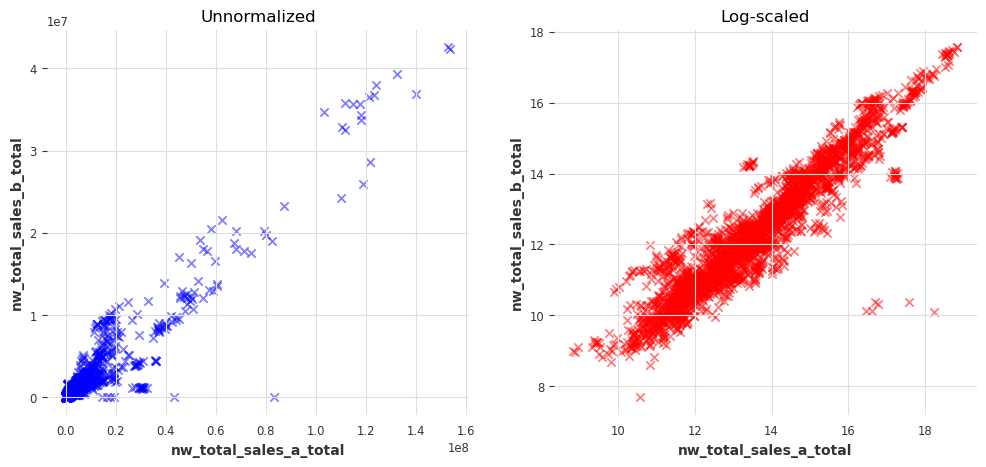

In [8]:
vis.plot_scatter_log(df,'nw_total_sales_a_total', 'nw_total_sales_b_total')

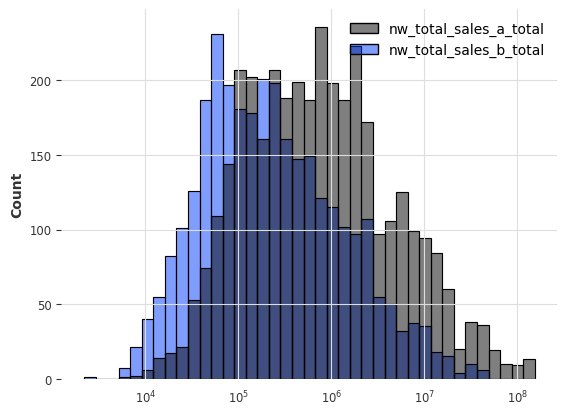

In [9]:
vis.plot_hist(df, 'nw_total_sales_a_total','nw_total_sales_b_total' )


We see that the distributions are quite similar but shifted, and that they have a fairly linear relationship when we apply the log. Thus, a linear least squares approach is justified. Including the other columns give a higher degree of freedom, but it could be justified to just use these columns up against each other.

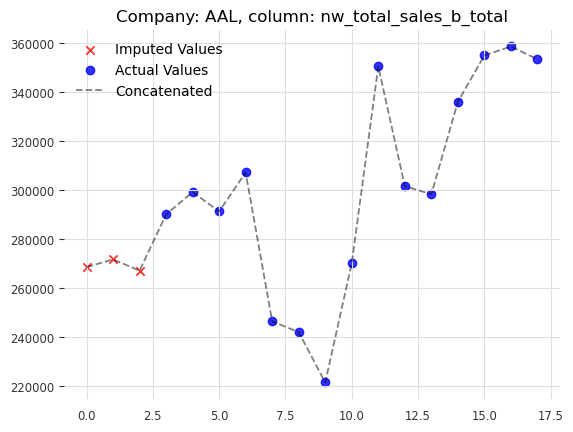

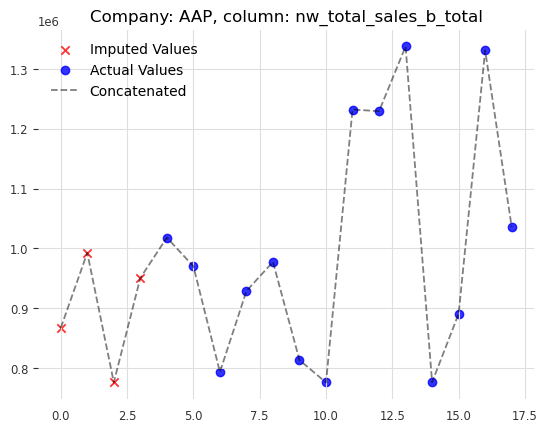

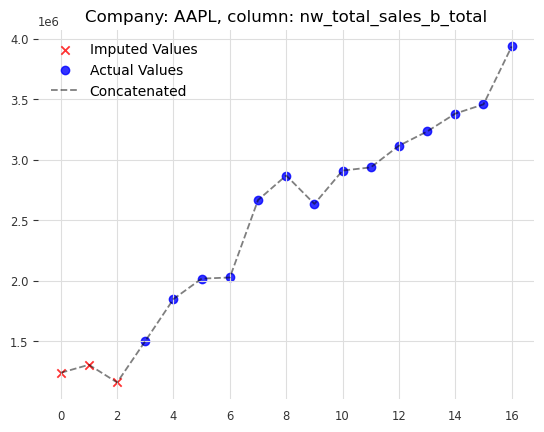

In [10]:
df = dw.impute_nans_singular_column(df, col='nw_total_sales_b_total' ,plot=True, max_plots=3)

Based on the plots a LLS solution looks sensible to the following time series, and thus handles many of the missing datapoints. The accuracy of these are however unknown. Bayesian regression can be performed to quantify uncertainty on the imputation on the missing values. To avoid noisy inputs, one could also perform lasso/ridge regression to shrink mutual information features and reduce high variance issues.   

In [11]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal        58
Sales_Estimate_fiscal      91
year                        0
month                       0
quarter                     0
dtype: int64

We see that the Actual and Estimated sales for fiscal quarters have a decent amount of NaN values. Thus, we can statistically inspect them as well, and see if there are favorable methods of imputation of these.

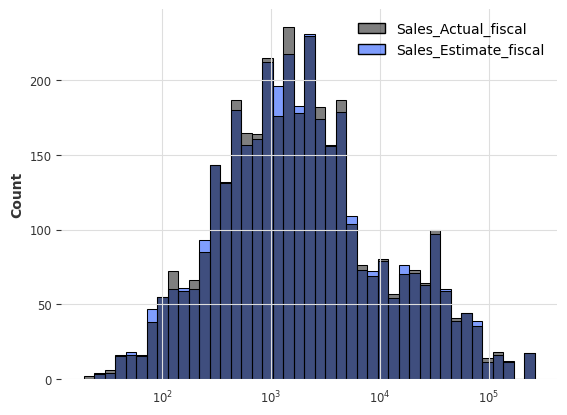

In [12]:
vis.plot_hist(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

The distributions have a very large overlap. Note that the distribution is a concetanation of all companies, so even though this looks normal, it is not necessarily the case for the distribution of actual sales and estimated sales with respect to the company in question.

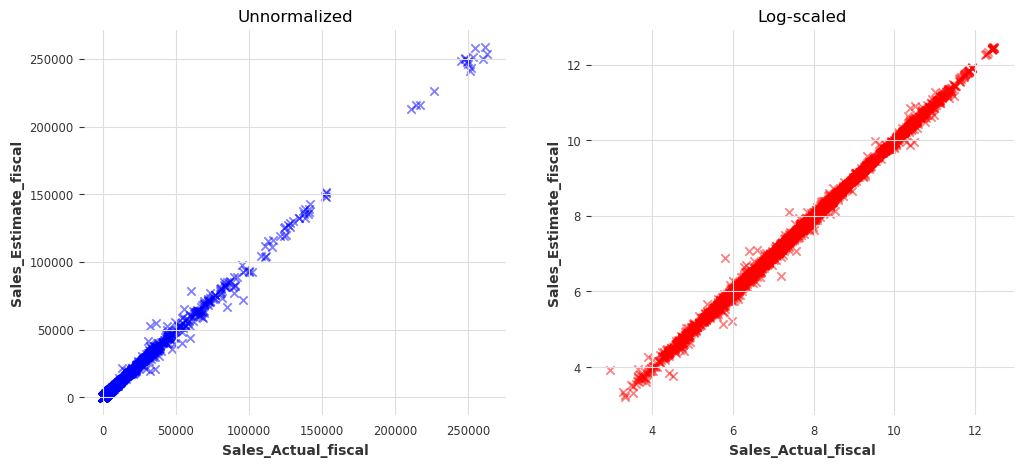

In [13]:
vis.plot_scatter_log(df, 'Sales_Actual_fiscal', 'Sales_Estimate_fiscal')

From this it looks as they are very linearly correlated. Let's inspect how it looks like for respective companies

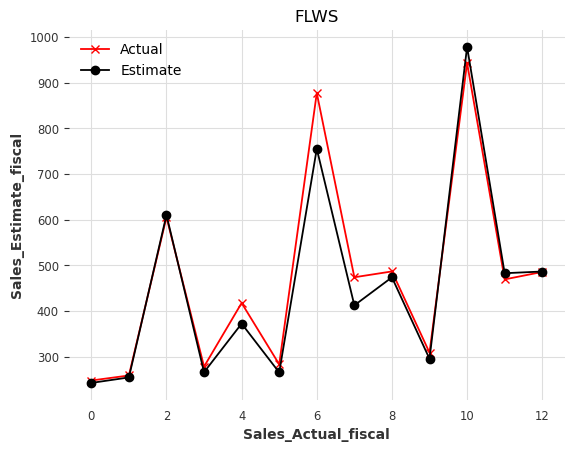

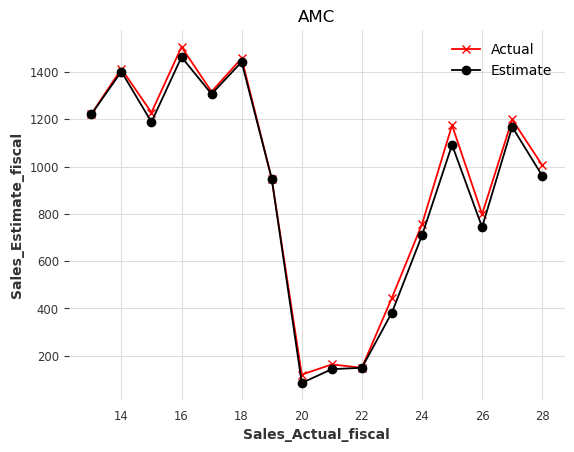

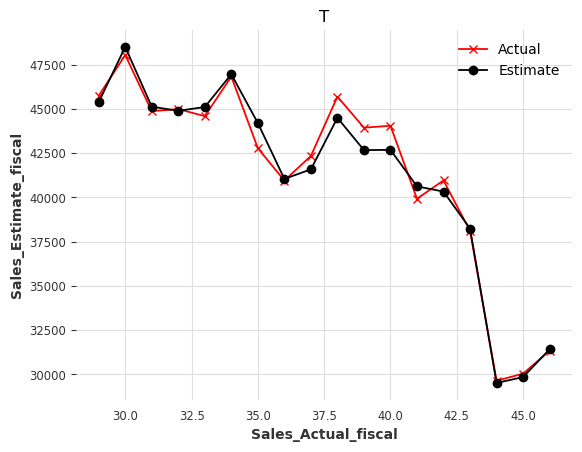

In [14]:
vis.plot_sales_comparison(df, max_plots=3)

It is evident that there are many instances for which the fiscal sales are missing for both estimate and actual, for that reason, we should apply an algorithm that can impute the missing values well. When both have NaNs at the same index over a time span ~5 there are uncertainty with doing rolling averages as there are fluctuations between quarters for many companies. The suggested idea would be to that of a KNN or KD-Ball algorithm to replace these instances. However, for the instances when there are rows when one or the other is present, it makes sense to impute values based on the other. Applying a normal centered at the no NaN column value at the corresponding index with a standard deviation that is the square root of the absolute difference of numeric rows seems like a intuitive and good solution based on their distribution. Also, when there is just a singular column of these with NaN values after doing the computations, we can perform LLS like earlier on those columns, given linearity exists in the dataset for these instances.

In [15]:
df = dw.fiscal_sales_imputation(df, plot=False)

### Remaining NaNs

In [16]:
df.isna().sum()

mic                         0
ticker                      0
time                        0
nw_total_sales_a_total    158
nw_total_sales_b_total    192
Sales_Actual_fiscal         0
Sales_Estimate_fiscal       0
year                        0
month                       0
quarter                     0
dtype: int64

For many of the total sales in A and B these are overlapping. A strategy here could be to use KNN / KD-Balls, Decision Trees or other ML algorithms for imputations

In [17]:
dw.print_nans_companies(df)



Ticker: ACI, # Data points: 18
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2]


Ticker: AEP, # Data points: 14
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Ticker: ASO, # Data points: 15
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 6, 7, 8, 11, 12, 14]


Ticker: BARK, # Data points: 9
Column: nw_total_sales_b_total, NaN Indices: [2, 3, 4, 5, 6, 7, 8]


Ticker: BJRI, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [7]
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 15]


Ticker: BKE, # Data points: 12
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


Ticker: BOOT, # Data points: 11
Column: nw_total_sales_a_total, NaN Indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Ticker: CAR, # Data points: 17
Column: nw_total_sales_b_total, NaN Indices: [0, 1, 2, 6, 7, 9]


Ticker: CASY, # Data points: 17
Column: nw_total_sales_a_total, NaN Indices: [2]
Column: nw_total_sa

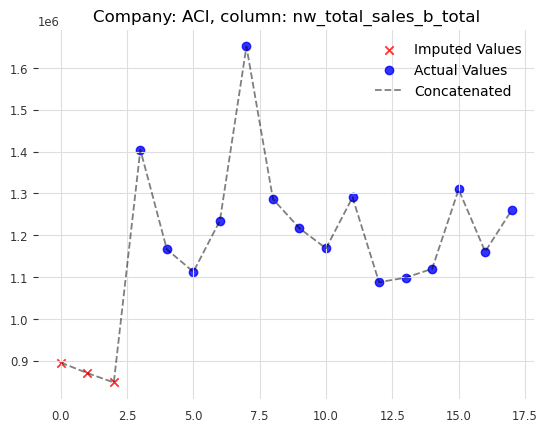

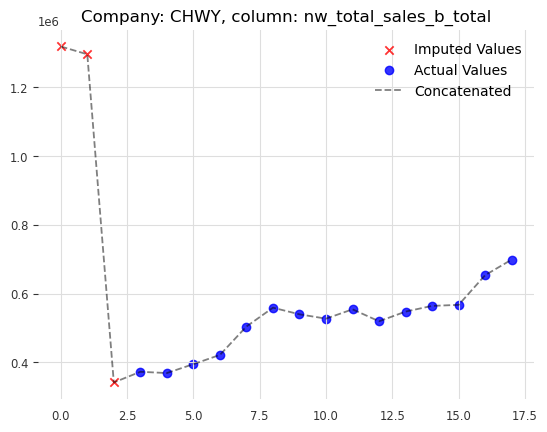

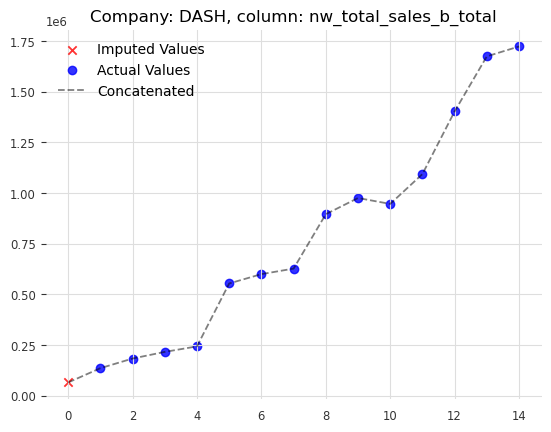

In [18]:
df = dw.impute_nans_singular_column(df, col='nw_total_sales_b_total',plot=True, max_plots=3)

It can seem as this is cause for some anomolies when performing LLS. Let's create a pipeline to detect anomolies.

In [19]:
df.ticker.unique()

array(['FLWS', 'AMC', 'T', 'ANF', 'ASO', 'ATVI', 'ADBE', 'AAP', 'ACI',
       'GOOGL', 'ATUS', 'AMZN', 'AMXL', 'AAL', 'AEO', 'AEP', 'AAPL',
       'ARMK', 'AZO', 'CAR', 'BARK', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY',
       'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG', 'BOOT', 'EAT', 'BBW', 'BURL',
       'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI', 'CASY', 'FUN', 'CHTR',
       'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH', 'CMPR', 'CNK',
       'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX', 'CUBE', 'DISH',
       'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS', 'DIN', 'DG',
       'DLTR', 'DPZ', 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EL', 'ETSY',
       'EB', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR',
       'FL', 'FTV', 'FRG', 'FTDR', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
       'GCO', 'GPC', 'GDDY', 'GRPN', 'HOG', 'HLF', 'HIBB', 'HLT', 'HUM',
       'H', 'IAC', 'INTU', 'JACK', 'JBLU', 'KSS', 'AD', 'DNUT', 'MC',
       'LEVI', 'LYV', 'LOW', 'LYFT', 'M', 'MPC', 'MAR', 'MTCH', '

In [20]:
df = dw.impute_nans_singular_column(df)

In [21]:
df = df.dropna(how='any')
df = dw.remove_short_series(df)
print(df.shape, '\n')
print(df.isna().sum())


(3401, 10) 

mic                       0
ticker                    0
time                      0
nw_total_sales_a_total    0
nw_total_sales_b_total    0
Sales_Actual_fiscal       0
Sales_Estimate_fiscal     0
year                      0
month                     0
quarter                   0
dtype: int64


# Creating new columns with high correlation to target

In [22]:
df = dw.add_proportion_ab(df)
df = dw.add_quarterly_yoy(df)
df = dw.add_prod(df)

In [23]:
df.ticker.unique()

array(['AMC', 'T', 'ANF', 'ATVI', 'ADBE', 'AAP', 'ACI', 'GOOGL', 'ATUS',
       'AMZN', 'AMXL', 'AAL', 'AEO', 'AAPL', 'ARMK', 'AZO', 'CAR', 'BJRI',
       'BJ', 'BP', 'BBWI', 'BBBY', 'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG',
       'EAT', 'BBW', 'BURL', 'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI',
       'CASY', 'CHTR', 'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH',
       'CMPR', 'CNK', 'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX',
       'CUBE', 'DISH', 'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS',
       'DIN', 'DG', 'DLTR', 'DPZ', 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA',
       'EL', 'ETSY', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR',
       'FLTR', 'FL', 'FTV', 'FRG', 'ULCC', 'GME', 'GPS', 'GEN', 'GM',
       'GCO', 'GPC', 'GDDY', 'GRPN', 'HOG', 'HLF', 'HLT', 'H', 'INTU',
       'JACK', 'JBLU', 'KSS', 'AD', 'DNUT', 'MC', 'LYV', 'LOW', 'LYFT',
       'M', 'MPC', 'MAR', 'MTCH', 'MCD', 'META', 'MSFT', 'MGI', 'MUSA',
       'NKE', 'NAVI', 'NFLX', 'NWL', 'NDLS', 'JWN', 'ORLY',

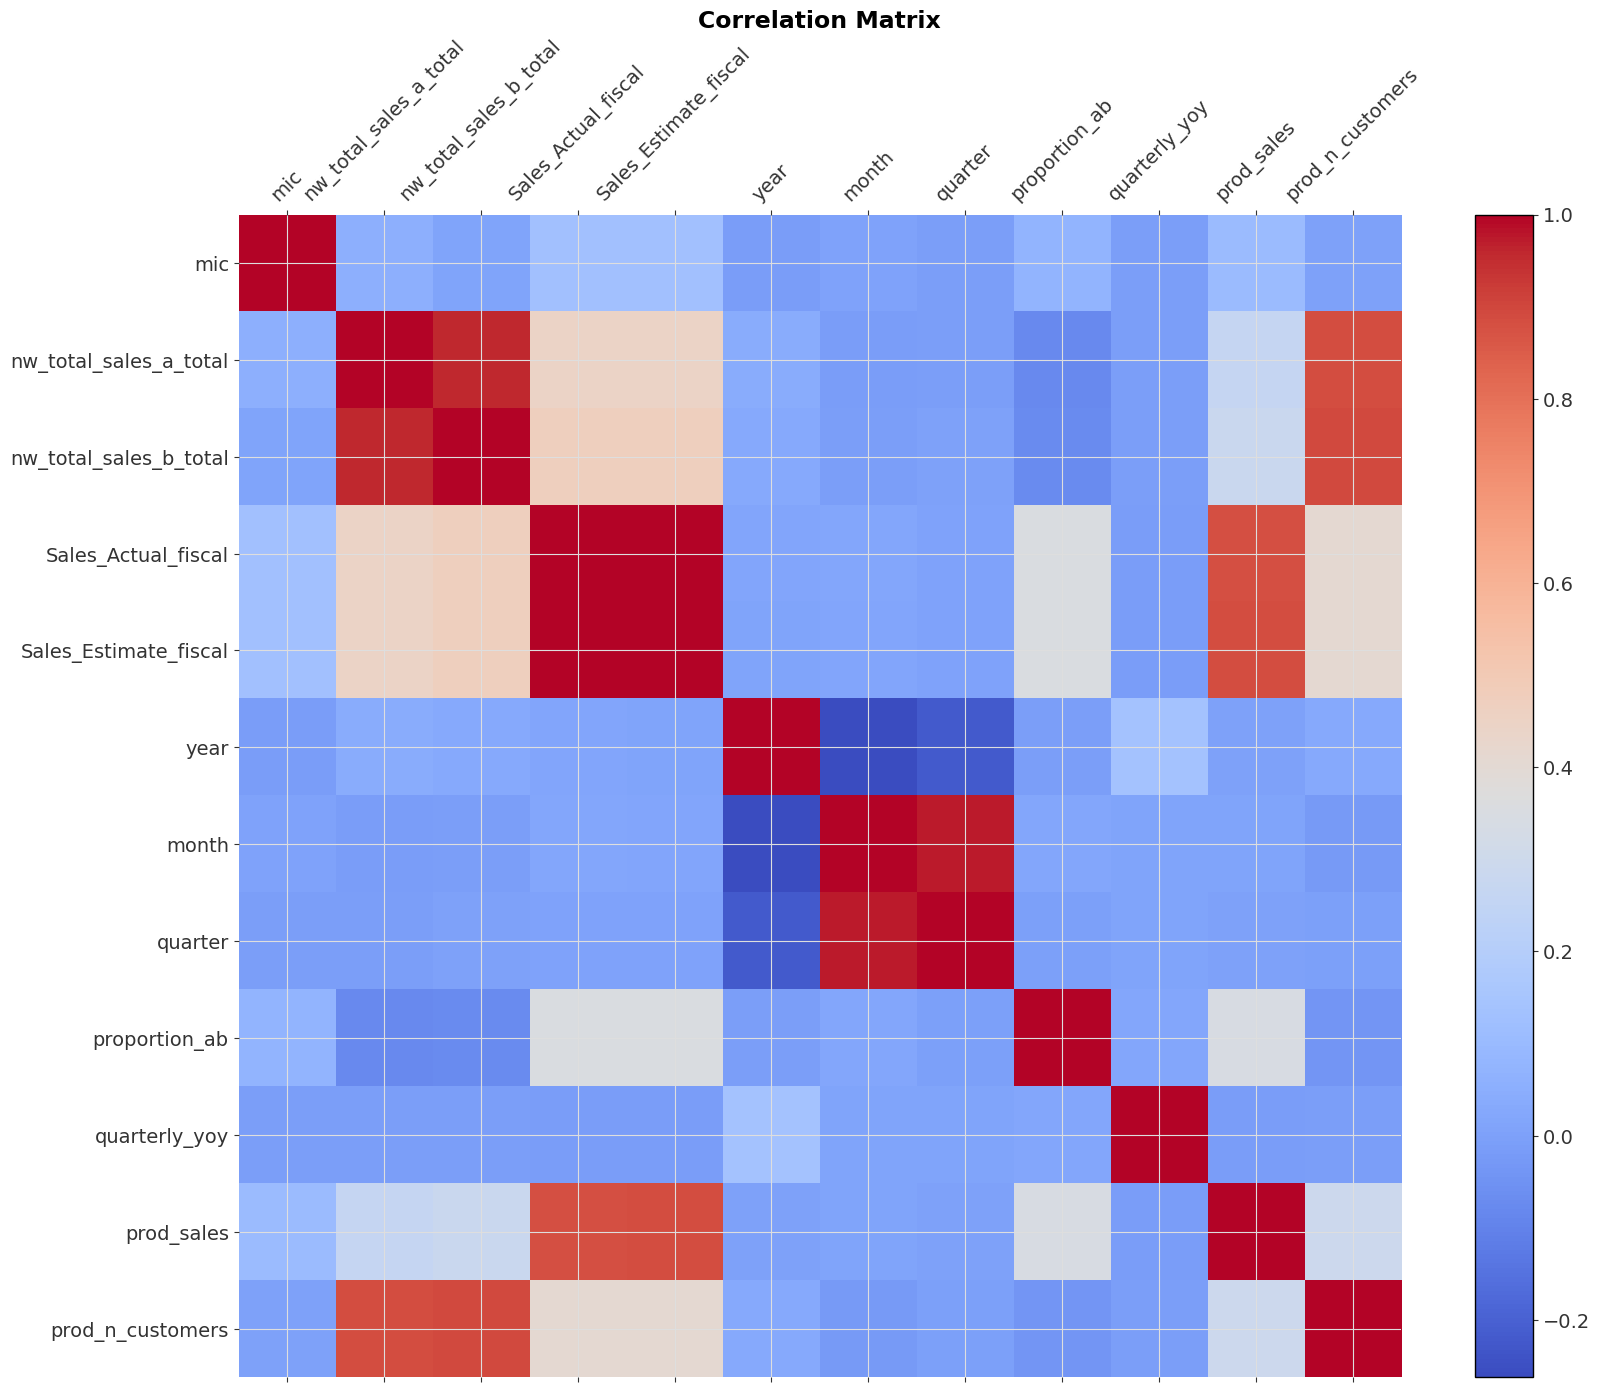

In [24]:
vis.plot_correlation_matrix(df)

The **key** to understanding here is that the high uncorrelation comes from the fact that we have a dataframe containing companies in different market segments with completely different scales to their sales by season, size of company etc., so looking at the whole dataframe gives a misleading correlation to the actual ground truth. If we take a single company, we can see that the correlation between columns will change drastically.

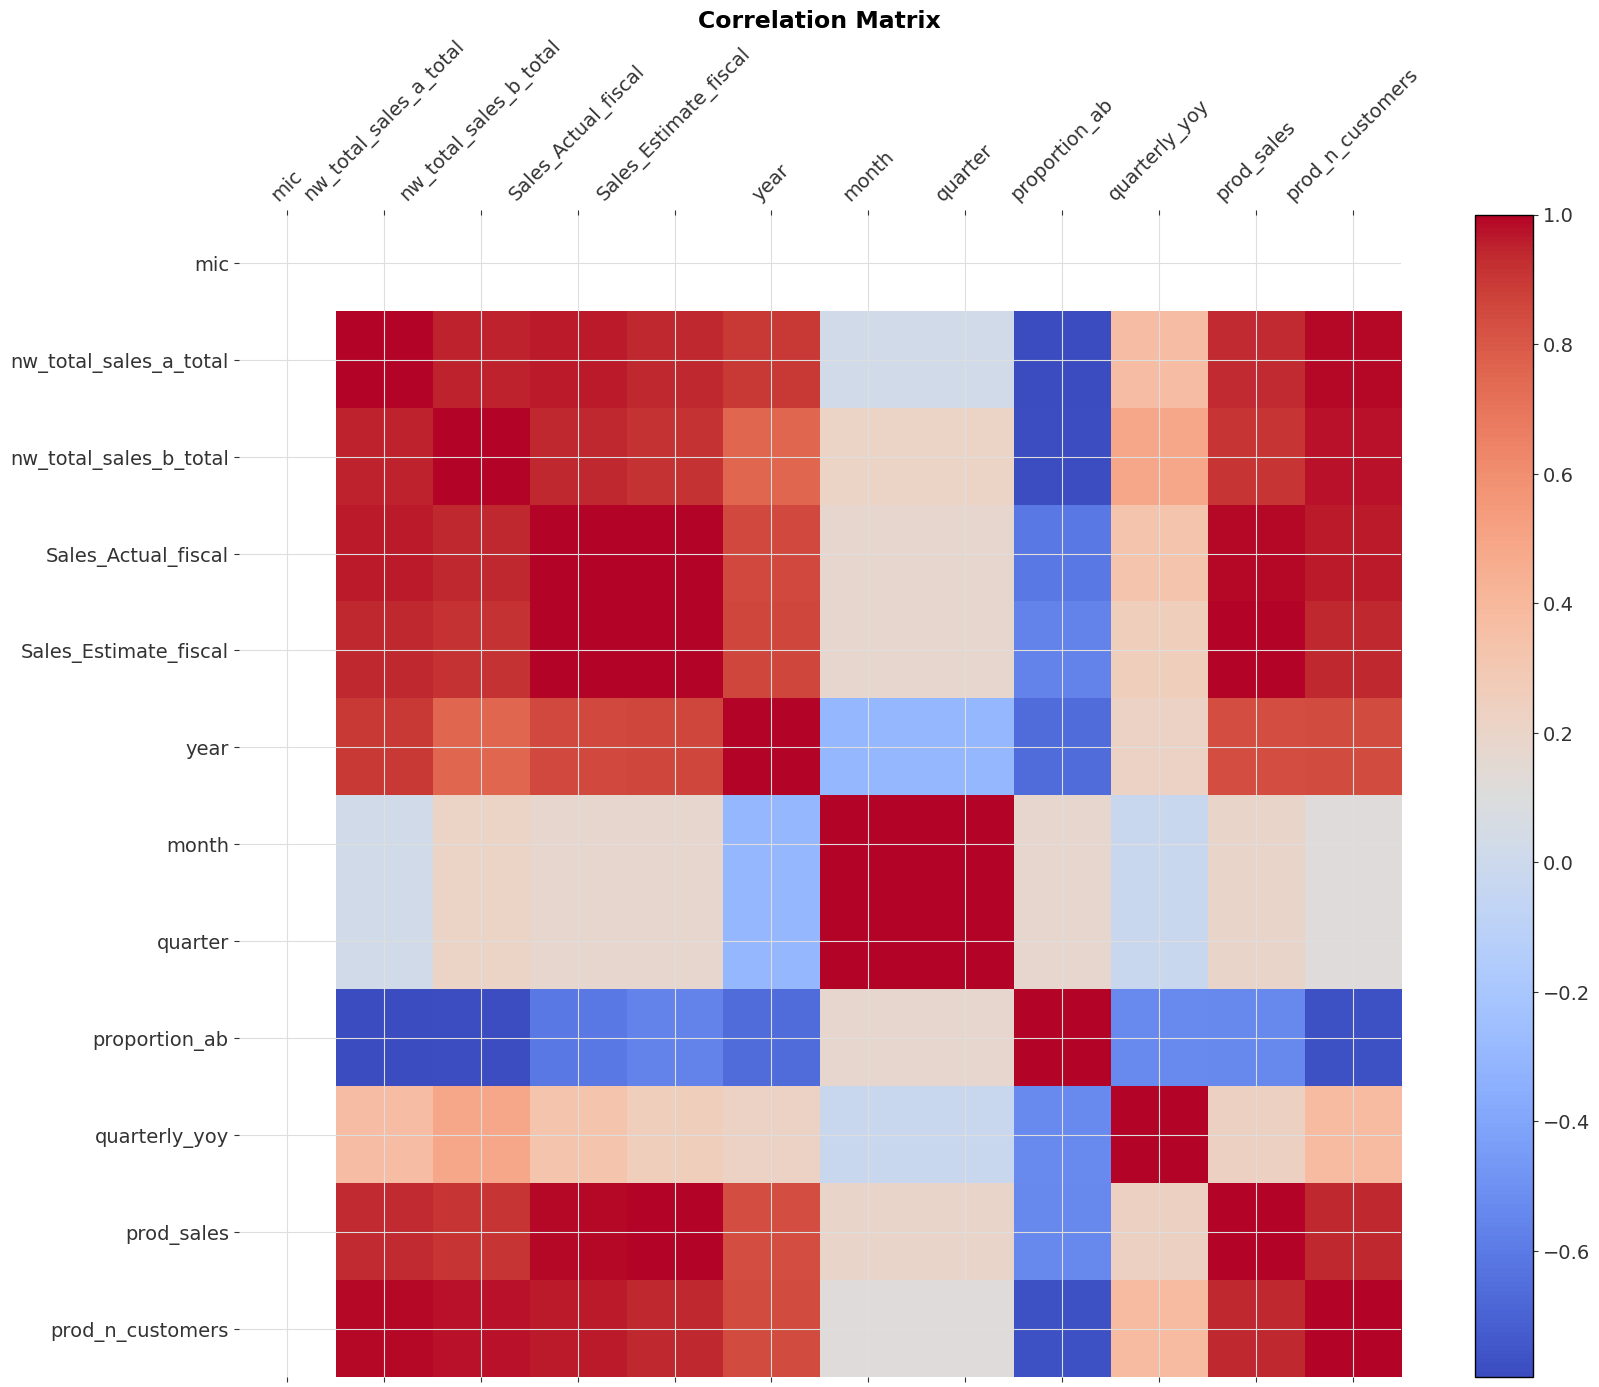

In [25]:
brand = 'AMZN'
df_brand = df[df['ticker'] == brand]
vis.plot_correlation_matrix(df_brand)

Therefore, the removal of columns is done by the respective ticker. If the overall mean covariance across all companies is below a threshold (set to 0.1), we remove it. Luckily for us there seem to be a very high correlation between actual sales to all other features

In [26]:
corr = df.groupby('ticker').apply(lambda x: x.corrwith(x['Sales_Actual_fiscal'], numeric_only=True)).mean()
corr = corr.sort_values(ascending=False)
corr


Sales_Actual_fiscal       1.000000
prod_sales                0.980774
Sales_Estimate_fiscal     0.955713
nw_total_sales_a_total    0.612237
prod_n_customers          0.591299
nw_total_sales_b_total    0.536225
quarterly_yoy             0.473007
year                      0.355703
proportion_ab             0.315863
quarter                   0.010866
month                    -0.003001
mic                            NaN
dtype: float64

In [27]:
# function to drop low correlation features
df = dw.drop_low_correlation_features(df)

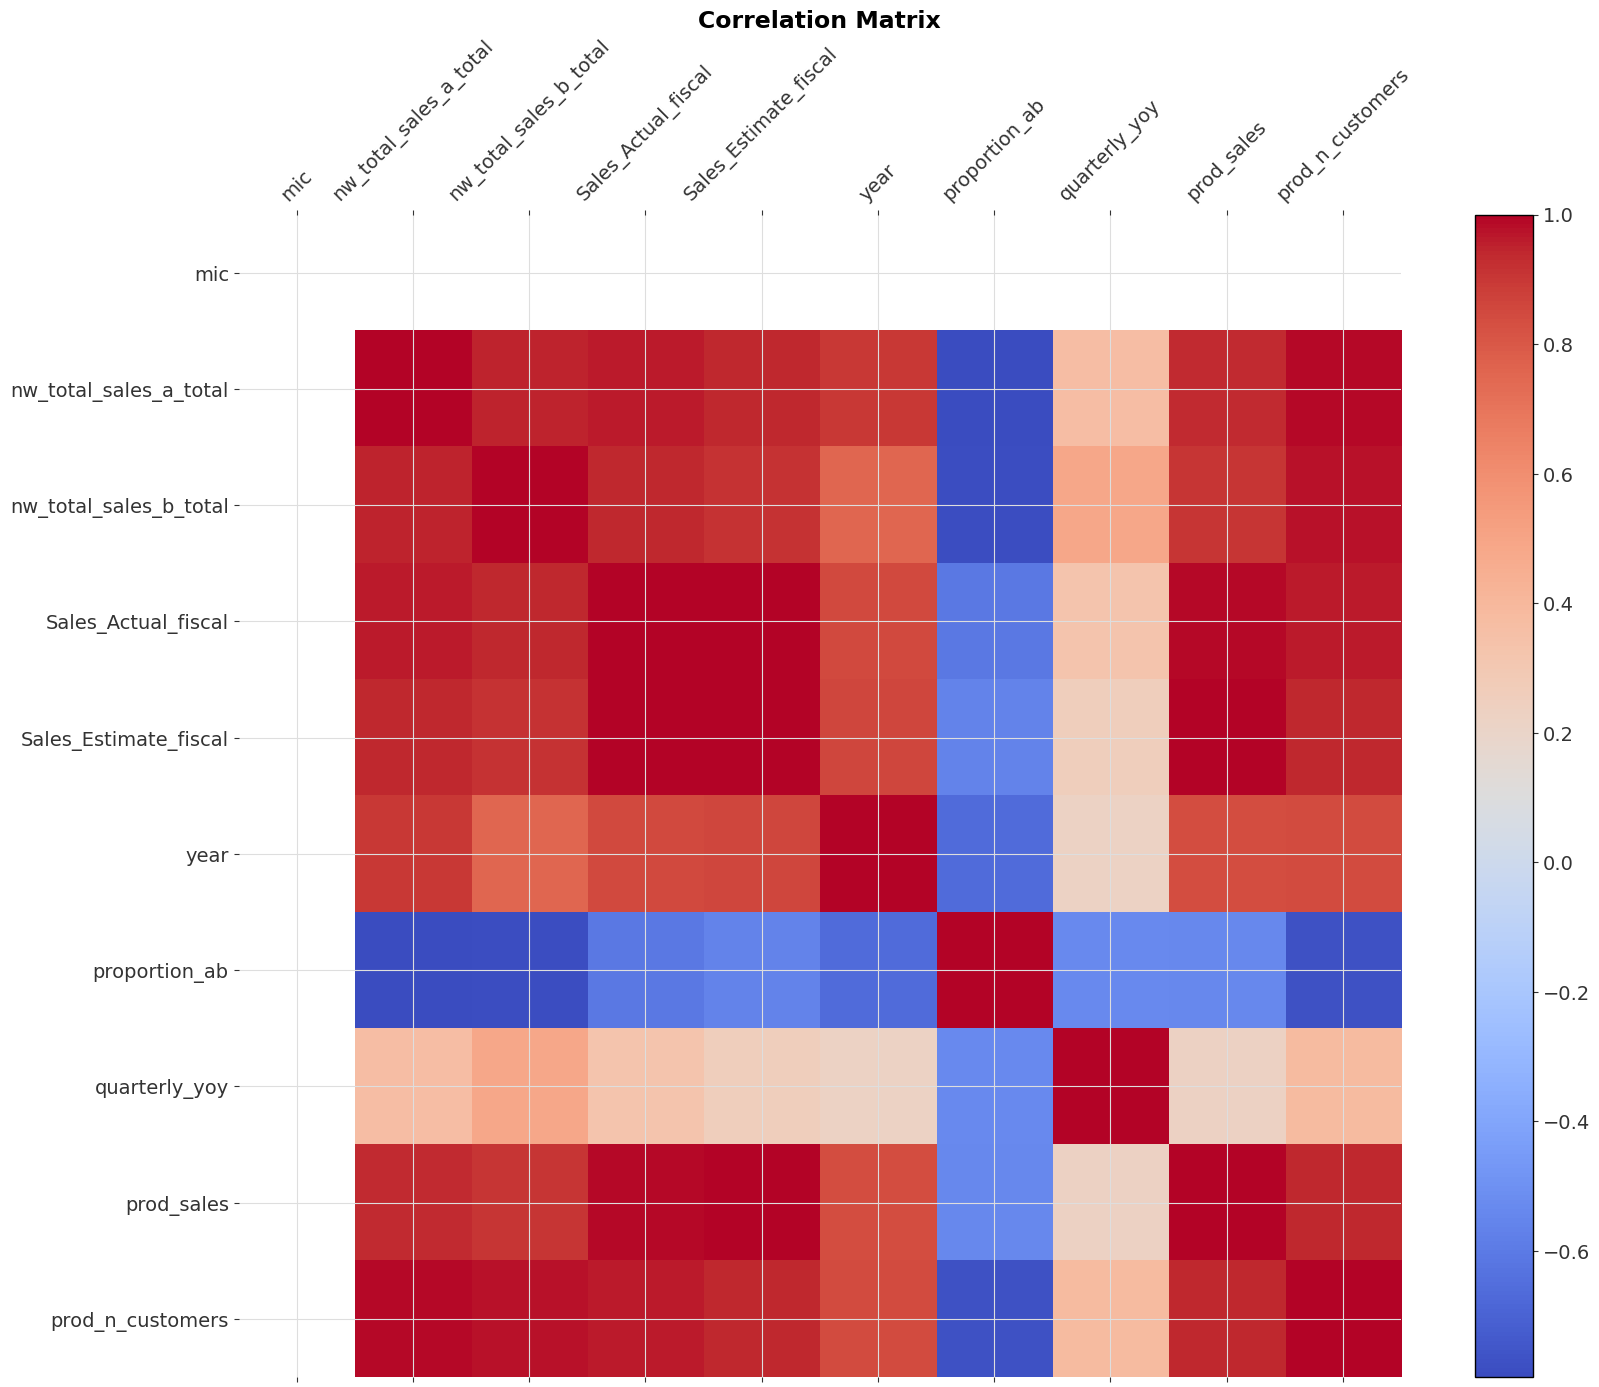

In [28]:
df_brand = df[df.ticker == 'AMZN']
vis.plot_correlation_matrix(df_brand)

The impact of covid and other macro economic events can have a significant impact on the sales. This we see in the reflection of the year's correlation with sales. An underlying factor for why this is so high is probably due to the effect of pre-mid-post COVID.

# Building Series in Darts
Note that the data frame must be thoroughly processed before starting this process, and keep in mind to that the model actually does handle NaNs implicitly. So, the thorough removal may not be neccessary. Especially, the line when all NaNs are dropped. Darts also has it's own models for imputations, but due to the structure of the data in this project, manual imputation using simple statistics was done.

As we create time series in darts, our model can support stationary covariates. As there is significant differences between companies in their sales volume, seasonalities, etc. we include this information to the model we are about to create. Thus, we must encode the stationary covariates, which we can do by mapping the tickers to a numeric value. To avoid numeric instability to the mapping, we do not do integer encoding as we have >200 companies to evaluate. This is to avoid any arbitrary ordering of assigning integer values. To have the model capture the stationary covariates there are two alternatives that seem reasonable:  
  
1. One Hot Encoding:   
Represent the tickers as one hot encoded covariates added to the function.
  
2. Mapping:  
Map the company to a range of somewhat similar float values to avoid numerical instability 
 
Now, because the number of companies exceeds the number of rows by a significant amount, it is uncertain whether the network will carry an advantage of adding so many stationary covariates. Thus, I have gone with option 2.

In [29]:
df, inv_mapper = dw.encode_float(df, 'ticker')

Functions above help extract appropriate covariates and target for each company within the data frame

### Converting the data frame into series for each company

In [30]:
series_dict = tsp.dict_series(df, inv_mapper)
series_dict.keys()

dict_keys(['AMC', 'T', 'ANF', 'ATVI', 'ADBE', 'AAP', 'ACI', 'GOOGL', 'ATUS', 'AMZN', 'AMXL', 'AAL', 'AEO', 'AAPL', 'ARMK', 'AZO', 'CAR', 'BJRI', 'BJ', 'BP', 'BBWI', 'BBBY', 'BBY', 'BIG', 'SQ', 'BLMN', 'BKNG', 'EAT', 'BBW', 'BURL', 'CVS', 'CAL', 'CTLP', 'CPRI', 'CCL', 'CRI', 'CASY', 'CHTR', 'CAKE', 'CHGG', 'CVX', 'CHWY', 'CHS', 'CMG', 'CHH', 'CMPR', 'CNK', 'CTRN', 'CMCSA', 'COP', 'COST', 'CBRL', 'CROX', 'CUBE', 'DISH', 'DRI', 'PLAY', 'DAL', 'DENN', 'DBI', 'DKS', 'DDS', 'DIN', 'DG', 'DLTR', 'DPZ', 'DASH', 'DKNG', 'DBX', 'DLTH', 'EA', 'EL', 'ETSY', 'ES', 'EXPE', 'EXPR', 'XOM', 'FDX', 'FIVE', 'FVRR', 'FLTR', 'FL', 'FTV', 'FRG', 'ULCC', 'GME', 'GPS', 'GEN', 'GM', 'GCO', 'GPC', 'GDDY', 'GRPN', 'HOG', 'HLF', 'HLT', 'H', 'INTU', 'JACK', 'JBLU', 'KSS', 'AD', 'DNUT', 'MC', 'LYV', 'LOW', 'LYFT', 'M', 'MPC', 'MAR', 'MTCH', 'MCD', 'META', 'MSFT', 'MGI', 'MUSA', 'NKE', 'NAVI', 'NFLX', 'NWL', 'NDLS', 'JWN', 'ORLY', 'OLLI', 'PZZA', 'PRTYQ', 'PYPL', 'PTON', 'PSX', 'PLNT', 'POSH', 'PBPB', 'PGR', 'DGX', 

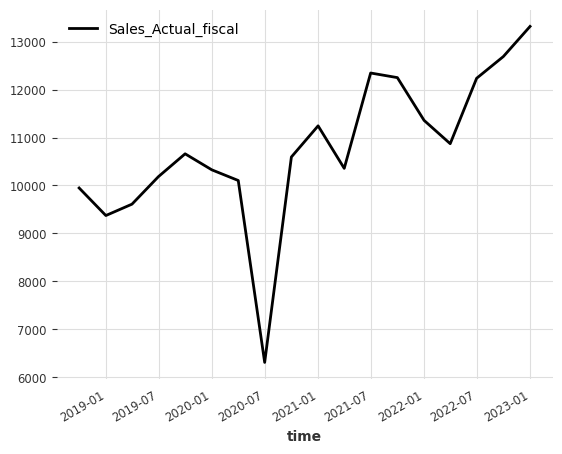

In [31]:
series_dict['NKE'][1].plot()

In [32]:
def past_future_split(series_dict, n_preds=2):
    """
    Split the time series into past and future covariate sets. Make lists for the train and test sets.
    It makes lists for past covariates and future covariates.
    The series dict consist of the time series for each company. Its values are the tuples of (covariates, target).

    Args:
        series_dict (dict): dictionary of time series. The keys are the tickers and the values are the tuples of (covariates, target).
        n_preds (int): number of predictions to make. Default is 2.
    
    Returns:
        past_cov (list): list of past covariates.
        future_cov (list): list of future covariates.
        target (list): list of targets.
        tickers (list): list of tickers.
    They share the same indices with respect to the company.
    """
    result = [(value[0][:-n_preds], value[0][-n_preds:], value[1], key) for key, value in series_dict.items()]
    past_cov, future_cov, target, tickers = zip(*result)
    return past_cov, future_cov, target, tickers

In [33]:
past_cov, future_cov, target, tickers = past_future_split(series_dict, n_preds=2)

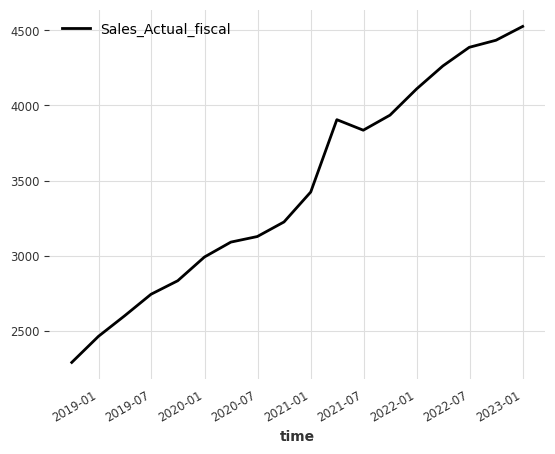

In [37]:
target[4].plot()

In [38]:
a = np.arange(10)
a[-10:]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [52]:
def match_input_length(past_cov, future_cov, target, tickers, min_train = 10):
    """
    Match the input and output length of the train covariates and train target.
    All the components of train_cov should have the same length.
    The function removes the early values of components that are longer than the minimum length.
    The function removes the instances that have less than the minimum length from the covariates, target and the ticker
    as they all have matching indices with respect to company name.

    Args:
        past_cov (list): list of past covariates time series objects.
        future_cov (list): list of future covariates time series objects.
        target (list): list of target time series objects.
        tickers (list): list of tickers.
        min_train (int): minimum length of the train covariates. Default is 10.
    
    Returns:
        past_cov (list): list of past covariates with the same length.
        future_cov (list): list of future covariates.
        target (list): list of target.
        tickers (list): list of tickers.
    The indices of the lists are ordered with respect to the same company.
    """
    min_length_series = min([len(x) for x in past_cov])

    if min_length_series > min_train:
        min_train = min_length_series

    past_cov = [x[-min_train:] for x in past_cov]

    # Remove instances that have less than the minimum length from train and test sets
    mask = [len(x) >= min_train for x in past_cov]
    past_cov, future_cov, target, tickers = [[lst[i] for i in range(len(lst)) if mask[i]] for lst in [past_cov, future_cov, target, tickers]]
    
    combined_length = min_train + len(future_cov[0])
    target = [target[-combined_length:] for target in target]

    return past_cov, future_cov, target, tickers

    

In [53]:
past_cov, future_cov, target, tickers = match_input_length(past_cov, future_cov, target, tickers, min_train = 12)

In [54]:
def scale_series(past_cov, future_cov, target):
    """
    Scale the time series using the Scaler class from darts.
    Scalers are fit on the covariates and  target for each company.
    The scalers are applied on the past and future covariates and the target.
    
    It scales seperately the covariates and the target as well as seperately for each company.
    The inverse scalers are also returned to be used for the inverse transformation of the predictions.
    Thus, the results can be interpreted in the original scale.

    Args:
        past_cov (list): list of past covariates.
        future_cov (list): list of future covariates.
        target (list): list of target.

    Returns:
        past_cov (list): list of scaled past covariates.
        future_cov (list): list of scaled future covariates.
        target (list): list of scaled target.
        scaler_cov (list): list of scalers for the covariates.
        scaler_target (list): list of scalers for the target.
    """
    scaler_cov = [Scaler().fit(x) for x in past_cov]
    past_cov = [scaler.transform(x) for x, scaler in zip(past_cov, scaler_cov)]
    future_cov = [scaler.transform(x) for x, scaler in zip(future_cov, scaler_cov)]

    scaler_target = [Scaler().fit(x) for x in target]
    target = [scaler.transform(x) for x, scaler in zip(target, scaler_target)]

    return past_cov, future_cov, target, scaler_cov, scaler_target



In [55]:
past_cov, future_cov, target, scaler_cov, scaler_target = scale_series(past_cov, future_cov, target)

## N-Beats settings

In [59]:
epochs = 200                        # number of epochs
n_stacks = 2                        # number of stacks in model
n_blocks = 5                        # number of blocks in model        
layer_width = 128                   # numer of weights in FC layer
batch = 50                          # batch size
lr = 1e-3                           # learning rate
val_wait = 1                        # epochs to wait before evaluating the loss on the test/validation set
seed = 42                           # random seed for regenerating results
n_samples = 100                     # number of times a prediction is sampled from a probabilistic model
n_jobs = -1                         # parallel processors to use;  -1 = all processors
split_proportion = 0.9              # train/test proportion
input_length = len(past_cov[0])     # length of the input sequence
output_length = len(future_cov[0])  # length of the output sequence

# quantiles for QuantileRegression argument
quantiles = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

# lower and upper quantiles for predictions
QL1, QL2 = 0.01, 0.05 
QU1, QU2 = 1 - QL1, 1 - QL2 
# labels for plotting
labelQ1 = f'{int(QU1 * 100)} / {int(QL1 * 100)} percentile band'
labelQ2 = f'{int(QU2 * 100)} / {int(QL2 * 100)} percentile band'


In [ ]:
def train_test_split(target):
    # TODO 
    pass
    

In [60]:
model_nbeats = NBEATSModel(input_chunk_length=len(past_cov[0]), 
                     output_chunk_length=len(future_cov[0]),
                     num_stacks=n_stacks,
                     num_blocks=n_blocks,
                     layer_widths=layer_width,
                     n_epochs=epochs,
                     likelihood = QuantileRegression(quantiles),
                     optimizer_kwargs = {"lr" : 1e-3},
                     generic_architecture=True,
                     trend_polynomial_degree=2,
                     random_state=seed,
                     nr_epochs_val_period=val_wait,
                     #pl_trainer_kwargs = {"accelerator": "cpu", "devices": 8 } 
                     )
predictor_nbeats = model_nbeats.fit(series=target, 
                       past_covariates=past_cov,               
                       verbose=False,
                       epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=200` reached.


In [ ]:
# TODO make a function for predicting using darts predictor - see docs
                                

In [ ]:
def plot_series_covs(covariates, series_train, series_test, idx):
    covariates[idx].plot(label='past covariates', linestyle='--')
    series_train[idx].plot(color='black')
    series_test[idx].plot(color='black')
    plt.legend().set_visible(False)
    plt.show()

plot_series_covs(past_cov, series_train, series_test, 3)

In [ ]:
def plot_prediction(predictor, train, test, covs, idx, n_preds=2):
    pred = predictor.predict(series=series_train[idx],
                         n=n_preds, 
                         past_covariates=covs[idx],
                         n_jobs=-1)
    pred.plot(label='Prediction', marker='o', color='red', low_quantile=0.05, high_quantile=0.95)
    train[idx].plot(marker='x', color ='blue', label='')
    test[idx].plot(marker='x', color ='blue')
    plt.legend();
    plt.show();

plot_prediction(predictor_nbeats, series_train, series_test, past_covariates, idx=2, n_preds=output_length)

In [ ]:
parameters = {
        "input_chunk_length" :  [input_length, input_length-2],
        "output_chunk_length" : [output_length],
        "num_stacks" :          [1,2,3,4,5],
        "num_blocks" :          [1,2,3],
        "num_layers" :          [1,2],
        "layer_widths" :        [128,256],
        "n_epochs" :            [20],
        "random_state" :        [1],
        }

result = NBEATSModel.gridsearch(
                parameters=parameters,
                series= [val[1] for val in series_dict.values()],
                past_covariates=past_covariates,
                forecast_horizon=output_length,
                metric=rmse,
                n_jobs=-1,
                verbose=True,
                n_random_samples=0.9,
        )

# Hyperparameter Tuning


### N-Beats / RNN (Architecture Design)  
* n_layers
* n_stacks
* input_chunk_length (lookback window of the model)
* output_chunk_length (how many steps into the future we make predictions)


In [ ]:
print(result)

In [ ]:
def eval_model(model, target, past_covariates=None, future_covariates=None, forecast_horizon=4, proportion_train=0.75):
    
    backtest = model.historical_forecasts(series=target, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon)
    print('RMSE = {}'.format(metrics.rmse(target, backtest)))

def grid_search(train_series,input_length, output_length, train_style='slice'):
    """ 
    
    """
    assert train_style in ['slice', 'split'], "need to have train_style set to either slice or split"
    # TODO - add splitting of series for doing grid search
    parameters = {
        "input_chunk_length" : [input_length - i for i in range(4)],
        "output_chunk_length" : [1,2],
        "num_stacks" : [1,2,3,4],
        "num_blocks" : None,
        "num_layers" : None,
        "layer_width" : None,
        "n_epochs" : None,
        "nr_epochs_val_period" : None,
        "batch_size" : None,
        "random_state" : [1],
        }
    if train_style == 'slice':
        result = NBEATSModel.gridsearch(
                parameters=parameters,
                series=train_series,
                start=input_length + 1,
                forecast_horizon=output_length,
                metric=rmse,
                n_jobs=-1,
                last_points_only=True,
                verbose=True,
                n_random_samples=0.9)

In [ ]:
from darts.models import XGBModel

xgb_model = XGBModel(
    lags=input_length,
    lags_past_covariates=input_length,
    lags_future_covariates=output_length,
    output_chunk_length=output_length,
    likelihood=QuantileRegression(quantiles),
    n_jobs=-1,
    random_state=seed,
    multi_models=False,
)

xgb_predictor = xgb_model.fit(series=series_train,
                              past_covariates=past_covariates,
                              future_covariates=future_covariates,
                              verbose=True)
